In [5]:
# imports
import os
import cv2
import glob
import random
import numpy as np
from PIL import Image
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image


## Unzipping Data

In [6]:
# !gdown -O miniproj2_ds_vid.zip "https://drive.google.com/uc?export=download&id=1JAehhAZ4SZkY0gXIBO09l-21j-kcottd"

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1JAehhAZ4SZkY0gXIBO09l-21j-kcottd
From (redirected): https://drive.google.com/uc?export=download&id=1JAehhAZ4SZkY0gXIBO09l-21j-kcottd&confirm=t&uuid=d6102028-0e68-41ae-859a-f91935a32dbe
To: c:\Users\Dell\Desktop\Vishal\miniproj2_ds_vid.zip

  0%|          | 0.00/149M [00:00<?, ?B/s]
  0%|          | 524k/149M [00:00<01:50, 1.34MB/s]
  1%|          | 1.57M/149M [00:00<00:40, 3.65MB/s]
  2%|▏         | 3.15M/149M [00:00<00:21, 6.85MB/s]
  3%|▎         | 4.72M/149M [00:00<00:15, 9.13MB/s]
  5%|▍         | 6.82M/149M [00:00<00:12, 11.2MB/s]
  6%|▌         | 8.39M/149M [00:00<00:11, 12.1MB/s]
  7%|▋         | 9.96M/149M [00:01<00:10, 13.0MB/s]
  8%|▊         | 12.1M/149M [00:01<00:09, 14.1MB/s]
  9%|▉         | 13.6M/149M [00:01<00:09, 14.4MB/s]
 10%|█         | 15.2M/149M [00:01<00:09, 14.7MB/s]
 11%|█▏        | 16.8M/149M [00:01<00:08, 14.8MB/s]
 12%|█▏        | 18.4M/149M [00:01<00:08, 15.0MB/s]
 13%|█▎       

In [8]:
# !unzip -q ./miniproj2_ds_vid.zip

## Loading data

In [6]:
path = './miniproj2_ds_vid/'
listOfCategories = os.listdir(path)
listOfCategories, len(listOfCategories)

(['laugh', 'pick', 'pour', 'pullup', 'punch'], 5)

In [7]:
table_data = []
for cat in listOfCategories:
    path2acat = os.path.join(path, cat)
    videos = os.listdir(path2acat)
    table_data.append([cat, len(videos)])

headers = ["Category", "Number of Videos"]
table = tabulate(table_data, headers, tablefmt="grid")
print(table)

+------------+--------------------+
| Category   |   Number of Videos |
+============+====================+
| laugh      |                 80 |
+------------+--------------------+
| pick       |                 80 |
+------------+--------------------+
| pour       |                 80 |
+------------+--------------------+
| pullup     |                 79 |
+------------+--------------------+
| punch      |                 80 |
+------------+--------------------+


In [8]:
def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename)
    # Get number of frames
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # creates sequences of evenly spaced values within a defined interval
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    v_cap.release()
    return frames, v_len

def store_frames(frames, path2store):
    for i, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        path2img = os.path.join(path2store, "frame"+str(i)+".jpg")
        cv2.imwrite(path2img, frame)

In [9]:
extension = ".avi"
n_frames = 16
sub_folder = 'miniproj2_ds_vid'
sub_folder_jpg = 'miniproj2_ds_jpg'
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        if extension not in name:
            continue
        path2vid = os.path.join(root, name)
        frames, vlen = get_frames(path2vid, n_frames= n_frames)
        path2store = path2vid.replace(sub_folder, sub_folder_jpg)
        path2store = path2store.replace(extension, "")
        os.makedirs(path2store, exist_ok= True)
        store_frames(frames, path2store)

In [10]:
def get_vids(path2ajpgs):
    listOfCats = os.listdir(path2ajpgs)
    ids = []
    labels = []
    for catg in listOfCats:
        path2catg = os.path.join(path2ajpgs, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg,los) for los in listOfSubCats]
        ids.extend(path2subCats)
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels, listOfCats

all_vids, all_labels, catgs = get_vids('./miniproj2_ds_jpg/')
len(all_vids), len(all_labels), len(catgs)

(399, 399, 5)

In [24]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict

{'laugh': 0, 'pick': 1, 'pour': 2, 'pullup': 3, 'punch': 4}

In [25]:
num_classes = 5
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)

(399, 399)

In [26]:
# Provides train/test indices to split data in train/test sets.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

319 319
80 80


In [27]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform, timesteps):
      self.transform = transform
      self.ids = ids
      self.labels = labels
      self.timesteps = timesteps

    def __len__(self):
      return len(self.ids)

    def __getitem__(self, idx):
      path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
      path2imgs = path2imgs[ : self.timesteps]
      label = labels_dict[self.labels[idx]]
      frames = []
      for p2i in path2imgs:
        frame = Image.open(p2i)
        frames.append(frame)


      frames_tr = []
      for frame in frames:
        frame = self.transform(frame)
        frames_tr.append(frame)
      if len(frames_tr)>0:
        frames_tr = torch.stack(frames_tr)
      return frames_tr, label

In [28]:
h, w = 128, 128
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [29]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer, timesteps=n_frames)
print(len(train_ds))

test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer, timesteps=n_frames)
print(len(test_ds))

319
80


In [30]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

def show(imgs):
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    for ii,img in enumerate(imgs[::2]):
        plt.subplot(1,8,ii+1)
        plt.imshow(denormalize(img, mean, std))
        plt.axis("off")

0


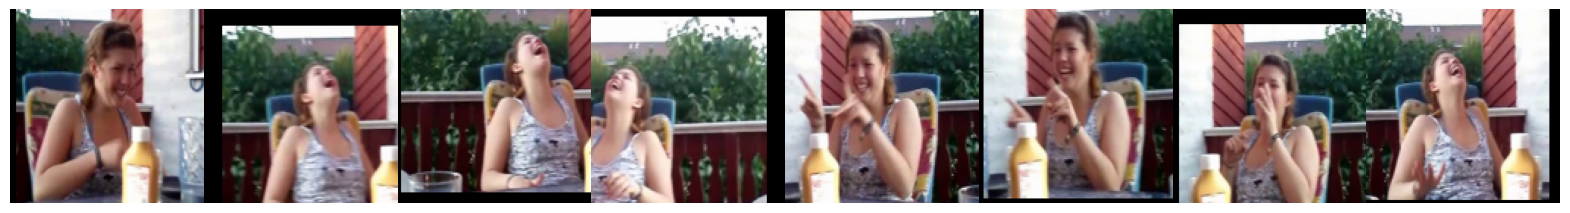

In [31]:
imgs, label = train_ds[5]
show(imgs)
print(label)

2


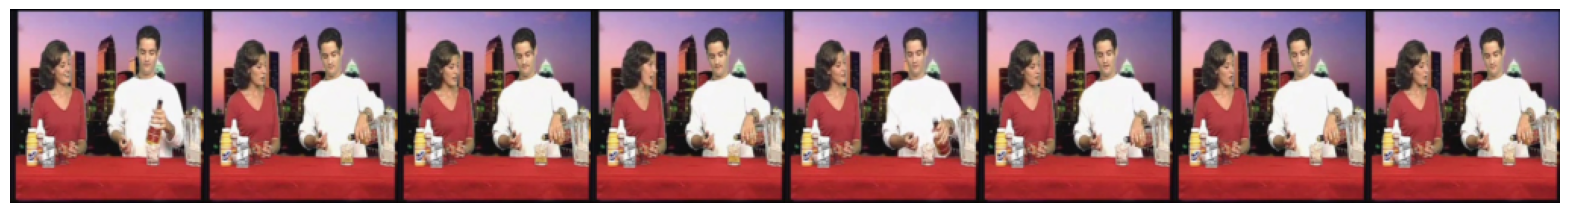

In [32]:
imgs, label = test_ds[50]
show(imgs)
print(label)

In [70]:
train_dataloader = DataLoader(train_ds, batch_size=4,
                        shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_ds, batch_size=4,
                        shuffle=False, num_workers=0)

## Model

In [104]:
class Net3D(nn.Module):
    def __init__(self):
        super(Net3D, self).__init__()

        #calling conv3d module for convolution
        self.conv1 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2)

        #calling MaxPool3d module for max pooling with downsampling of 2
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=2)

        self.conv2 =  nn.Conv3d(in_channels = 32, out_channels = 50, kernel_size = (1,3,3), stride = 2)

        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2)

        #fully connected layer
        self.fc1 = nn.Linear(50*7*7, 1024)
        self.fc2 = nn.Linear(1024, 5)


    # defining the structure of the network
    def forward(self, x):
        # Applying relu activation after each conv layer
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 50*7*7)

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))

        # Output layer (no activation)
        x = self.fc2(x)

        return x

fixed_model_3d = Net3D().cuda()

#Printing the network architecture
print(fixed_model_3d)


Net3D(
  (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
  (pool1): MaxPool3d(kernel_size=(1, 3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 50, kernel_size=(1, 3, 3), stride=(2, 2, 2))
  (pool2): MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2450, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)


In [105]:
loss_fn = nn.CrossEntropyLoss()
initial_lr = 1e-2
optimizer = optim.SGD(fixed_model_3d.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [106]:
def train_3d(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    print_every = 20
    for epoch in range(num_epochs):
        loss=0
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        # check_accuracy_3d(model, test_dataloader)
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = sample[0].cuda()
            y_var = sample[1].long().cuda()

            scores = model(x_var)

            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

def check_accuracy_3d(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = sample[0].cuda()
        y_var = sample[1]
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)

        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [107]:
fixed_model_3d.train()
train_3d(fixed_model_3d, loss_fn, optimizer,train_dataloader, num_epochs=25)


Starting epoch 1 / 25
t = 20, loss = 1.5855
t = 40, loss = 1.6756
t = 60, loss = 1.6384
t = 80, loss = 1.6721
Starting epoch 2 / 25
t = 20, loss = 1.2761
t = 40, loss = 1.4054
t = 60, loss = 1.6414
t = 80, loss = 1.1061
Starting epoch 3 / 25
t = 20, loss = 1.6369
t = 40, loss = 1.4061
t = 60, loss = 1.2086
t = 80, loss = 1.1951
Starting epoch 4 / 25
t = 20, loss = 0.8066
t = 40, loss = 1.1997
t = 60, loss = 1.7771
t = 80, loss = 1.4248
Starting epoch 5 / 25
t = 20, loss = 1.5068
t = 40, loss = 1.4978
t = 60, loss = 1.3830
t = 80, loss = 1.0932
Starting epoch 6 / 25
t = 20, loss = 0.5533
t = 40, loss = 0.7382
t = 60, loss = 1.5242
t = 80, loss = 0.5943
Starting epoch 7 / 25
t = 20, loss = 1.3357
t = 40, loss = 0.4729
t = 60, loss = 1.9077
t = 80, loss = 0.6492
Starting epoch 8 / 25
t = 20, loss = 1.0029
t = 40, loss = 1.2075
t = 60, loss = 0.6283
t = 80, loss = 1.0355
Starting epoch 9 / 25
t = 20, loss = 1.3412
t = 40, loss = 0.6882
t = 60, loss = 0.9374
t = 80, loss = 0.4432
Starting e

In [108]:
fixed_model_3d.eval()
check_accuracy_3d(fixed_model_3d, train_dataloader)
check_accuracy_3d(fixed_model_3d, test_dataloader)

Got 222 / 319 correct (69.59)
Got 49 / 80 correct (61.25)


In [109]:
class VideoDataset_Reduced(Dataset):
  def __init__(self, ids, labels, transform, timesteps):
      self.transform = transform
      self.ids = ids
      self.labels = labels
      self.timesteps = timesteps

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
    path2imgs = path2imgs[ : self.timesteps]
    label = labels_dict[self.labels[idx]]
    frames = []
    for p2i in path2imgs:
      frame = Image.open(p2i)
      frames.append(frame)

    # Randomly choose 2 to 8 frames and repeat them to get 16 frames
    num_frames_to_select = random.choice([2, 4, 6, 8])
    selected_frames = random.sample(frames, num_frames_to_select)
    repeated_frames = selected_frames * (16 // num_frames_to_select)

    while len(repeated_frames) < 16:
      # add repeated_frames[0] to pad or remove elements from the end to crop.
      repeated_frames.append(repeated_frames[0])

    frames_tr = []
    for frame in repeated_frames:
      frame = self.transform(frame)
      frames_tr.append(frame)

    if len(frames_tr)>0:
      frames_tr = torch.stack(frames_tr)

    return frames_tr, label

In [110]:
train_ds_repeated = VideoDataset_Reduced(ids= train_ids, labels= train_labels, transform= train_transformer, timesteps=n_frames)
print(len(train_ds))

test_ds_repeated = VideoDataset_Reduced(ids= test_ids, labels= test_labels, transform= test_transformer, timesteps=n_frames)
print(len(test_ds))

319
80


0


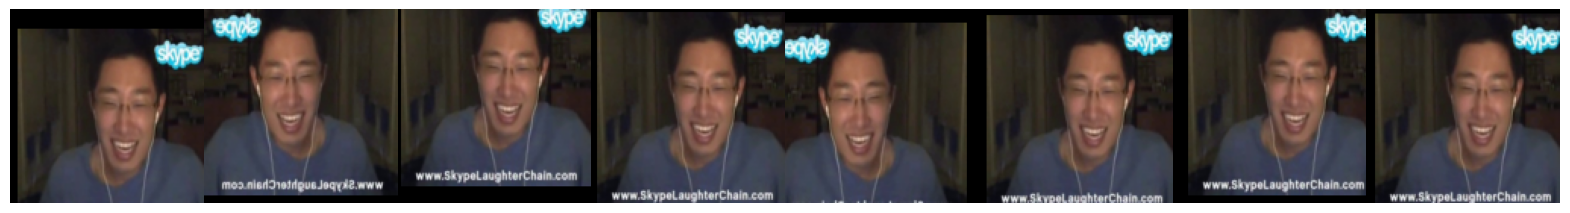

In [111]:
imgs, label = train_ds_repeated[10]
show(imgs)
print(label)

4


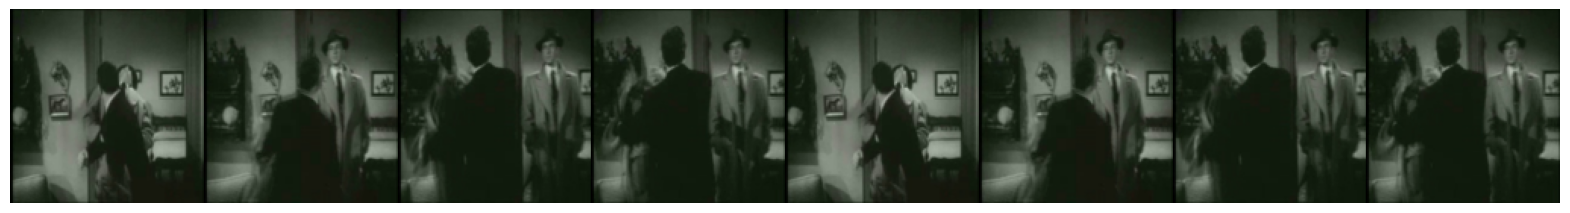

In [112]:
imgs, label = test_ds_repeated[7]
show(imgs)
print(label)

In [113]:
test_dataloader_repeat = DataLoader(test_ds_repeated, batch_size=4,
                        shuffle=False, num_workers=0)

In [114]:
check_accuracy_3d(fixed_model_3d, test_dataloader_repeat)

Got 46 / 80 correct (57.50)


In [115]:
# torch.save(fixed_model_3d.state_dict(), './model.pth')

In [196]:
class Model_Improved(nn.Module):
    def __init__(self):
        super(Model_Improved, self).__init__()

        #calling conv3d module for convolution
        self.conv1 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2)

        self.bn1 = nn.BatchNorm3d(32)

        #calling MaxPool3d module for max pooling with downsampling of 2
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=2)

        self.conv2 =  nn.Conv3d(in_channels = 32, out_channels = 128, kernel_size = (1,3,3), stride = 2)

        self.bn2 = nn.BatchNorm3d(128)

        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=2)

        # fully connected layer
        self.fc1 = nn.Linear(128*7*7, 1024)

        self.fc2 = nn.Linear(1024, 5)



    # defining the structure of the network
    def forward(self, x):
        # Applying relu activation after each conv layer
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 128*7*7)

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))

        # Output layer (no activation)
        x = self.fc2(x)

        return x



In [197]:
model2 = Model_Improved().cuda()

#Printing the network architecture
print(model2)

Model_Improved(
  (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool3d(kernel_size=(1, 3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 128, kernel_size=(1, 3, 3), stride=(2, 2, 2))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool3d(kernel_size=(1, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)


In [198]:
loss_fn = nn.CrossEntropyLoss()
initial_lr = 1e-2
optimizer = optim.SGD(model2.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [199]:
model2.train()
train_3d(model2, loss_fn, optimizer,train_dataloader, num_epochs=25)


Starting epoch 1 / 25
t = 20, loss = 1.9821
t = 40, loss = 1.8342
t = 60, loss = 1.6787
t = 80, loss = 1.2230
Starting epoch 2 / 25
t = 20, loss = 1.0957
t = 40, loss = 1.6035
t = 60, loss = 1.1369
t = 80, loss = 0.9690
Starting epoch 3 / 25
t = 20, loss = 1.8041
t = 40, loss = 1.0317
t = 60, loss = 0.9450
t = 80, loss = 2.3735
Starting epoch 4 / 25
t = 20, loss = 1.5706
t = 40, loss = 1.7071
t = 60, loss = 1.3402
t = 80, loss = 1.1331
Starting epoch 5 / 25
t = 20, loss = 0.9573
t = 40, loss = 1.7702
t = 60, loss = 1.7569
t = 80, loss = 0.6643
Starting epoch 6 / 25
t = 20, loss = 1.3325
t = 40, loss = 0.3719
t = 60, loss = 0.5177
t = 80, loss = 2.3250
Starting epoch 7 / 25
t = 20, loss = 1.6496
t = 40, loss = 1.0056
t = 60, loss = 0.3467
t = 80, loss = 0.2047
Starting epoch 8 / 25
t = 20, loss = 0.7185
t = 40, loss = 0.9521
t = 60, loss = 0.7700
t = 80, loss = 0.8090
Starting epoch 9 / 25
t = 20, loss = 0.7786
t = 40, loss = 0.5808
t = 60, loss = 0.3069
t = 80, loss = 1.4348
Starting e

In [200]:
check_accuracy_3d(model2, test_dataloader)
check_accuracy_3d(model2, test_dataloader_repeat)

Got 56 / 80 correct (70.00)
Got 54 / 80 correct (67.50)


In [202]:
# save both the models
torch.save(fixed_model_3d.state_dict(), './model.pth')
torch.save(model2.state_dict(), './model_improved.pth')

# load both the models
fixed_model_3d.load_state_dict(torch.load('./model.pth'))